In [1]:
import sys
sys.path.append("../")

from all_models import *

In [2]:
import os
import numpy as np
import codecs
import regex
import json

import seaborn
import matplotlib.pyplot as plt
from matplotlib import gridspec

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


class Task(object):

    def __init__(self):
        self.en_file = "data/train.tags.de-en.en"
        self.de_file = "data/train.tags.de-en.de"
        self.en_samples = self.get_samples(self.en_file)
        self.de_samples = self.get_samples(self.de_file)
        self.rand_de = np.random.RandomState(1)
        self.rand_en = np.random.RandomState(1)
        self.n_samples = len(self.en_samples)
        self.en_dict = json.load(open("data/en_dict.json", 'r', encoding='utf-8'))
        self.de_dict = json.load(open("data/de_dict.json", 'r', encoding='utf-8'))
        self.en_vocab_size = len(self.en_dict)
        self.de_vocab_size = len(self.de_dict)
        self.idx = 0

    def get_samples(self, file):
        text = codecs.open(file, 'r', 'utf-8').read().lower()
        text = regex.sub("<.*>.*</.*>\r\n", "", text)
        text = regex.sub("[^\n\s\p{Latin}']", "", text)
        samples = text.split('\n')
        return samples

    def embed(self, sample, dictionary, max_len=20, sos=False, eos=False):
        sample = sample.split()[:max_len]
        while len(sample) < max_len:
            sample.append('<PAD>')
        if sos:
            tokens = ['<START>']
        else:
            tokens = []
        tokens.extend(sample)
        if eos:
            tokens.append('<PAD>')
        idxs = []
        for token in tokens:
            try:
                idxs.append(dictionary.index(token))
            except:
                idxs.append(dictionary.index('<UNK>'))
        idxs = np.array(idxs)
        return np.eye(len(dictionary))[idxs]

    def next_batch(self, batchsize=64, max_len=20, idx=None):
        start = self.idx
        if idx is not None:
            start = idx
        end = start + batchsize
        if end > self.n_samples:
            end -= self.n_samples
            en_minibatch_text = self.en_samples[start:]
            self.rand_en.shuffle(self.en_samples)
            en_minibatch_text += self.en_samples[:end]
            de_minibatch_text = self.de_samples[start:]
            self.rand_de.shuffle(self.de_samples)
            de_minibatch_text += self.de_samples[:end]
        else:
            en_minibatch_text = self.en_samples[start:end]
            de_minibatch_text = self.de_samples[start:end]
        self.idx = end
        en_minibatch_in = []
        en_minibatch_out = []
        de_minibatch = []
        for sample in en_minibatch_text:
            en_minibatch_in.append(self.embed(sample, self.en_dict, max_len=max_len, sos=True))
            en_minibatch_out.append(self.embed(sample, self.en_dict, max_len=max_len, eos=True))
        for sample in de_minibatch_text:
            de_minibatch.append(self.embed(sample, self.de_dict, max_len=max_len))
        return np.array(de_minibatch), np.array(en_minibatch_in), np.array(en_minibatch_out)

    def prettify(self, sample, dictionary):
        idxs = np.argmax(sample, axis=1)
        return " ".join(np.array(dictionary)[idxs])

class TaskDataset(Dataset):
    def __init__(self, task, max_len):
        super().__init__()
        self.task = task
        self.max_len = max_len

    def __len__(self):
        return self.task.n_samples

    def __getitem__(self, i):
        ans = [x[0] for x in self.task.next_batch(
            batchsize=1,
            max_len=self.max_len,
            idx=i)]
        return ans

In [3]:
def train(max_len=20,
          batchsize=64,
          epochs=1,
          print_every=50,
          savepath='models/',
          cuda=torch.cuda.is_available()):

    os.makedirs(savepath, exist_ok=True)
    task = Task()
    device = torch.device('cuda:0' if cuda else 'cpu')
    print('Device: ', device)
    model = FullTransformerModel(task.en_vocab_size,task.de_vocab_size).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
    task_dataset = TaskDataset(task, int(max_len))
    # !!! Change num_workers to 0 when on a cpu
    task_dataloader = DataLoader(task_dataset,
                                 batch_size=batchsize,
                                 shuffle=True,
                                 drop_last=True,
                                 num_workers=0)

    for i in range(epochs):
        print('Epoch: ', i)
        this_epoch_loss = 0
        for j, a_batch in enumerate(task_dataloader):
            minibatch_enc_in, minibatch_dec_in, minibatch_dec_out = a_batch
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                minibatch_enc_in = minibatch_enc_in.float().to(device)
                minibatch_dec_in = minibatch_dec_in.float().to(device)
                minibatch_dec_out = minibatch_dec_out.to(device)
                out, _ = model(minibatch_enc_in, minibatch_dec_in)
                loss = F.cross_entropy(
                    out.transpose(1, 2),
                    minibatch_dec_out.argmax(dim=2))
                loss.backward()
                optimizer.step()
            loss = loss.detach().cpu().numpy()
            this_epoch_loss += loss
            if (j + 1) % print_every == 0:
                print("Iteration {} - Loss {}".format(j + 1, loss))

        this_epoch_loss /= (j + 1)
        print("Epoch {} - Loss {}".format(i, this_epoch_loss))

        lr_scheduler.step(this_epoch_loss)

        torch.save(model.state_dict(), savepath + '/ckpt_{}.pt'.format(str(i)))
        print('Model saved')

    print("Training complete!")
    torch.save(model.state_dict(), savepath + '/ckpt.pt')

In [4]:
def test(max_len=20,
         savepath='models/',
         plot=True,
         line=198405,
         cuda=torch.cuda.is_available()):

    task = Task()
    device = torch.device('cuda:0' if cuda else 'cpu')
    print('Device: ', device)
    model = FullTransformerModel(task.en_vocab_size,task.de_vocab_size).to(device)
    model_path = '/Users/schnuckiputz/Downloads/transformer-tutorial-task-5-20240105_142703.pt'
    # model_path = 'models/ckpt_0.pt'
    model.load_state_dict(torch.load(model_path, 
                                     map_location=torch.device(device)))
    idx = line
    if idx is None:
        idx = np.random.randint(low=0, high=task.n_samples)
        print('Predicting line :', idx)

    samples, _, truth = task.next_batch(batchsize=1, max_len=max_len, idx=idx)
    print("\nInput : \n{}".format(regex.sub("\s<PAD>", "", task.prettify(samples[0], task.de_dict))))
    print("\nTruth : \n{}".format(regex.sub("\s<PAD>", "", task.prettify(truth[0], task.en_dict))))

    output = ""
    for i in range(max_len):
        # During inference, you're correct that we don't know the entire target sequence ahead of time. Instead, we typically start with a special start-of-sequence token (often denoted as <SOS> or <START>) as the first input to the decoder.
        # Then, we run the decoder one step at a time. At each step, we take the output of the decoder from the previous step and use it as the input for the next step. This process is often referred to as "autoregressive decoding" because the model generates the output sequence one token at a time, using its own previous outputs as input for the next step.
        # So, for minibatch_dec_in during inference, you would start with the start-of-sequence token, and then iteratively fill in the rest of the sequence with the model's own output from the previous step.        
        
        # `output` - we keep feeding it back, repetatively
        predictions, attention = model(
            torch.Tensor(samples).to(device),
            torch.Tensor(task.embed(output, task.en_dict, sos=True)).to(device))
        predictions = predictions.detach().cpu().numpy()
        output += " " + task.prettify(predictions[0], task.en_dict).split()[i]
    print("\nOutput: \n{}".format(regex.sub("\s<PAD>", "", task.prettify(predictions[0], task.en_dict))))

    if plot:
        fig = plt.figure(figsize=(10, 10))
        gs = gridspec.GridSpec(2, 2, hspace=0.5, wspace=0.5)
        x_labels = regex.sub("\s<PAD>", "", task.prettify(samples[0], task.de_dict)).split()
        y_labels = regex.sub("\s<PAD>", "", task.prettify(predictions[0], task.en_dict)).split()
        for i in range(4):
            ax = plt.Subplot(fig, gs[i])
            head_attention = attention[i].squeeze(0).detach().numpy()
            seaborn.heatmap(
                data=head_attention[ :len(y_labels), :len(x_labels)],
                xticklabels=x_labels,
                yticklabels=y_labels,
                ax=ax,
                cmap='plasma',
                vmin=np.min(head_attention),
                vmax=np.max(head_attention),
                cbar=False)
            ax.set_title("Head {}".format(i))
            ax.set_aspect('equal')
            for tick in ax.get_xticklabels():
                tick.set_rotation(90)
            for tick in ax.get_yticklabels():
                tick.set_rotation(0)
            fig.add_subplot(ax)
        plt.show()

In [ ]:
# train()

Device:  cpu

Input : 
und wie ich gerade erklärt habe ist das ein problem

Truth : 
and as i was just <UNK> food <UNK> is a problem

Output: 
and i <UNK> i <UNK> is a <UNK>


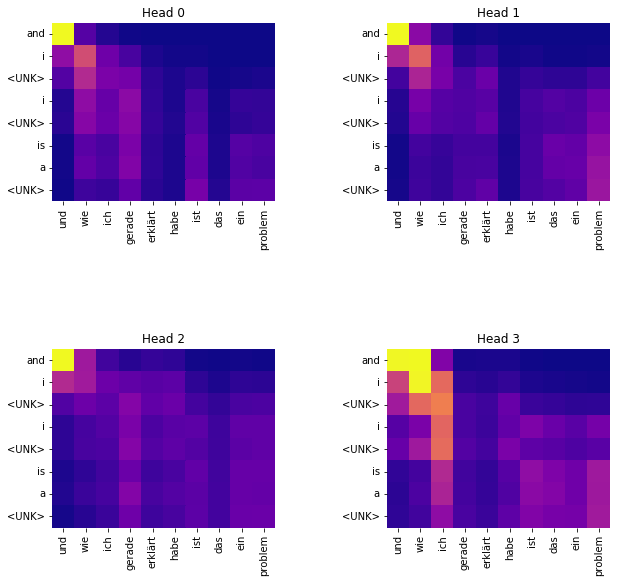

In [6]:
test(line=198405)